### Importing libraries

In [1]:
# pip install tensorflow
# check out https://www.tensorflow.org/tutorials/images/cnn
# can run and compare results in colab

In [2]:
# pip install keras-tuner

In [3]:
# pip install tensorboard
tensorboardPath = "C:/users/npess/appdata/roaming/python/python37/site-packages"

In [4]:
# python C:/users/npess/appdata/roaming/python/python37/site-packages/tensorflow/tensorboard/tensorboard.py --logdir=C:/Capstone/Wildfire_Detection_Capstone_697/logdir

In [5]:
# import tensorflow as tf
# # !pip install -q tf-nightly-2.0-preview
# !pip install tf-nightly-gpu-2.0-preview
# # Load the TensorBoard notebook extension
# %load_ext tensorboard
# # Clear any logs from previous runs
# !rm -rf ./logs/

In [42]:
import os
import pandas as pd
import numpy as np
import itertools

# import required libaries to process images
import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 
import altair as alt
import seaborn as sns
 
#using Keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, preprocessing
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorboard.plugins.hparams import api as hp
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard
# Clear any logs from previous runs
! rm -rf ./logs/
# print("GPU Available: ", tf.config.list_physical_devices('GPU'))

#sklearn
from sklearn.metrics import confusion_matrix

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
# !pip install -q tf-nightly-2.0-preview
# # Load the TensorBoard notebook extension
# %load_ext tensorboard

In [8]:
# logs_base_dir = "./logs"
# os.makedirs(logs_base_dir, exist_ok=True)
# %tensorboard --logdir {logs_base_dir}

### Importing and examining the images

In [9]:
def resize_image(img):
    width, height = img.size
    ratio = width/height
    new_height = 100
    new_width = int(new_height*ratio)
    img = img.resize((new_width, new_height))
    return img

In [10]:
# follow this on zero padding vs resizing and how it effects accuracy 
# mabye something we talk to Jiaqi about
def pad_images(images, width_max, length_max): 
    padded_images = [] 
    c = 0 
    for image in images: 
        wpad1 = (width_max - image.shape[0])/2
        lpad1 = (length_max - image.shape[1])/2

        if lpad1%1 > 0: 
            lpad1 = int(lpad1)
            lpad2 = int(lpad1)+1
        else: 
            lpad1 = int(lpad1)
            lpad2 = int(lpad1)

        if wpad1%1 > 0: 
            wpad1 = int(wpad1)
            wpad2 = int(wpad1)+1
        else: 
            wpad1 = int(wpad1)
            wpad2 = int(wpad1)
        try:
            padded_images.append(np.pad(image, pad_width=[(wpad1 , wpad2),(lpad1, lpad2),(0, 0)], mode='constant'))
        except: 
            print("at {}".format(c))
        c = c + 1
    return padded_images

In [11]:
#crop images to center based on full dataset mean_size
def crop_images(images, width_mean, length_mean):
    train_padded_c = []
    for image in images: 
        
        left = int((image.shape[0] - int(width_mean))/2)
        top = int((image.shape[1] - int(length_mean))/2)
        right = int((image.shape[0] + int(width_mean))/2)
        bottom = int((image.shape[1] + int(length_mean))/2)

        train_padded_c.append(image[left:right, top:bottom])
    return train_padded_c

In [12]:
#checking out the shape for standardization
def shaping (all_images):
    width_means = []
    length_means = []
    for array in all_images:

    #     print(array.shape)

        #width to length ratio
    #     print(array.shape[0]/array.shape[1])

        #width & length means
        width_means.append(array.shape[0])
        length_means.append(array.shape[1])

    width_mean = np.mean(width_means)
    length_mean = np.mean(length_means)

    return None

In [13]:
def get_image_stats(image_arrays):
    widths = [array.shape[0] for array in image_arrays]
    lengths = [array.shape[1] for array in image_arrays]
    width_mean = np.mean(widths)
    length_mean = np.mean(lengths)
    width_max = np.max(widths)
    length_max = np.max(lengths)
    return length_mean, length_max, width_max, width_mean

In [14]:
def load_images2(img_dir, type, height):
    ''' Type as int 0 no_fire 1 fire
        desired height of image as int 
        img_dir as str folder name where images stored'''

    #get list of images 
    dir = os.getcwd()
    rootdir = '{}/assets/{}'.format(dir, img_dir)
    data = []
    try:
        images = os.listdir(rootdir)
        image_file = [file for file in images if '.DS_Store' not in file]
        try:
            image_arrays = [np.asarray(resize_image(Image.open(f'{rootdir}/{image}'))) for image in image_file]
            label_arrays = []
            for array in image_arrays:
                label_arrays.append([type])
            image_labels = label_arrays
            data.extend(list(zip(image_arrays, image_labels)))
        except:
            for subpath in os.listdir(rootdir):
                d = os.path.join(rootdir, subpath)
                images = os.listdir(d)
                image_file = [file for file in images if '.DS_Store' not in file]
                try:
                    image_arrays = [np.asarray(resize_image(Image.open(f'{d}/{image}'))) for image in image_file]
                    label_arrays = []
                    for array in image_arrays:
                        label_arrays.append([type])
                    image_labels = label_arrays
                    data.extend(list(zip(image_arrays, image_labels)))
                except:
                    for subpath in os.listdir(d):
                        d2 = os.path.join(d,subpath)
                        images = os.listdir(d2)
                        print('d2 section')
                        image_file = [file for file in images if '.DS_Store' not in file]
                        if len(image_file)>1:
                            try:
                                print('final try')
                                image_arrays = [np.asarray(resize_image(Image.open(f'{d2}/{image}'))) for image in image_file]
                                label_arrays = []
                                for array in image_arrays:
                                    label_arrays.append([type])
                                image_labels = label_arrays
                                data.extend(list(zip(image_arrays, image_labels)))
                                print(data)
                            except:
                                pass
                        else:
                            pass
    except:
        pass
    
    #get_labels
    print('data')
    print(data)

    return data

In [15]:
def load_images(img_dir, type, height, aug=False):
    ''' Type as int 0 no_fire 1 fire
        desired height of image as int 
        img_dir as str folder name where images stored'''

    #get list of images
    if aug:
        image_file = img_dir
        image_arrays = [np.asarray(resize_image(image)) for image in image_file]
    else:
        dir = os.getcwd()
        images = os.listdir('{}/assets/{}'.format(dir, img_dir))
        image_file = [file for file in images if '.DS_Store' not in file]
        image_arrays = [np.asarray(resize_image(Image.open('{}/assets/{}/{}'.format(dir,img_dir, image)))) for image in image_file]
        paths = ['{}/assets/{}/{}'.format(dir,img_dir, image) for image in image_file]
#         print(paths) #for gitignore
    
    #get_labels
    label_arrays = []
    for array in image_arrays:
        label_arrays.append([type])
    image_labels = label_arrays

    data = list(zip(image_arrays, image_labels))

    return data


In [16]:
def storeImgs (datasets,folders,subfolders,smokeTypes,timeOfDay):
    data = []
    for dataset in datasets:
        if dataset.str.contains('-'):
            for smokeType in smokeTypes:
                for time in timeOfDay:
                    data.extend(load_images(f'{dataset}/{smokeType}/{time}', 1, 100))   
        else:
            data.extend(load_images({dataset}, 1, 100))
                

In [17]:
# wildfire_train_set_Unprocessed = load_images2('wildfire_train_set - Unprocessed', 1, 100)
# wildfire_test_set = load_images2('wildfire_test_set', 1, 100)
# mountain_test_set = load_images2('mountain_test_set', 1, 100)

In [18]:
# wildfire_test_set = load_images('wildfire_test_set', 1, 100)
# mountain_test_set = load_images('mountain_test_set', 0, 100)
nofire_unprocessed = load_images('wildfire_train_set - Base Forest - Unprocessed',0,100)
nofire_processed = load_images('wildfire_train_set - Base Forest - Processed',0,100)
smokeTypes = ['Heavy Smoke','Light Smoke']
timeOfDay = ['Night','Day','Morning']

data = []
# data.extend(wildfire_test_set)
# data.extend(mountain_test_set)
data.extend(nofire_unprocessed)
data.extend(nofire_processed)
for smokeType in smokeTypes:
    for time in timeOfDay:
        wildfire_train_set_Unprocessed = load_images(f'wildfire_train_set - Unprocessed/{smokeType}/{time}', 1, 100)
        data.extend(wildfire_train_set_Unprocessed)
        wildfire_train_set_Processed = load_images(f'wildfire_train_set - Processed and Pruned/{smokeType}/{time}', 1, 100)
        data.extend(wildfire_train_set_Processed)
        
print(len(data))

3324


In [19]:
def imageLabelAssembly(data, augment=False):

    images, labels = zip(*data)

    length_mean, length_max, width_max, width_mean = get_image_stats(images)

    #crop and pad images
    images_cropped = pad_images(images, width_max, length_max)
    images_final = crop_images(images_cropped, width_mean, length_mean)

    #convert all imagees to RGB some are ARGB
    images_final = [np.array(Image.fromarray(image).convert('RGB')) for image in images_final]

    if augment:
        data_augmentation = keras.Sequential(
          [
            layers.RandomFlip("vertical",
                              input_shape=input_shape),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
          ])
        
#         # plt.figure(figsize=(10, 10))
#         augmented_images = []
#         augmented_labels = []
#         # for images in train_images:
#         for i in range(len(train_images[:9])):
#             augmented_image = np.array(data_augmentation(tf.convert_to_tensor(images_final[i], dtype=tf.float32)))
#             augmented_label = labels[i]
#             augmented_images.append(data_augmentation(augmented_image))
#             augmented_labels.append(augmented_label)
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(augmented_image).numpy().astype("uint8")
#             plt.axis("off")
            
#         plt.figure(figsize=(10, 10))
#         for i in range(9):
#             augmented_image = data_augmentation(tf.convert_to_tensor(images_final, dtype=tf.float32)[i])
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(augmented_image)
#             plt.axis("off")
    else:
        pass

#     augmented = list(zip(augmented_images, augmented_labels))
    data = list(zip(images_final, labels))
    
    return data

data = imageLabelAssembly(data, augment=False)

In [20]:
def test_train_split(data):
    # randomize the images
    import random 
    random.seed(42)
    random.shuffle(data)

    #split into train, test, dev
    data_len = len(data)
    train, dev, test = np.split(data, [int(data_len*.8),int(data_len*.9)])
    train_images, train_labels = zip(*train)
    dev_images, dev_labels = zip(*dev)
    test_images, test_labels = zip(*test)
    
    return train_images, train_labels, dev_images, dev_labels, test_images, test_labels
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(data)

C:\Users\npess\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [21]:
#normalize the images
train_images, dev_images, test_images = np.array(train_images) / 255.0, \
                                        np.array(dev_images) / 255.0, \
                                        np.array(test_images) / 255.0,

In [22]:
#testing label application
def plot_images(images, labels):
    import math

    p_size = math.floor(math.sqrt(len(images)))

    class_names = ['no_fire','fire']
    plt.figure(figsize=(10,10))
    for i in range(p_size**2):
        plt.subplot(p_size,p_size,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i][0]])
    
# plot_images(train_images, train_labels)
# plot_images(test_images, test_labels)

In [23]:
input_shape = train_images.shape[1:]

In [24]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [25]:
# print(train_images.shape)
# print(np.asarray(train_labels).reshape(-1).shape)

In [26]:
# train_images = tf.data.Dataset.from_tensor_slices((train_images, np.asarray(train_labels).reshape(-1)))
# test_images = tf.data.Dataset.from_tensor_slices((test_images, np.asarray(test_labels).reshape(-1)))

In [27]:
train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

In [28]:
#sample model

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))#(100, 163, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 182, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 91, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 89, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 44, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 42, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 56448)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [29]:
#testing model

epochs=1

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=epochs, 
                    validation_data=(test_images, test_labels))

84/84 [==============================] - 32s 372ms/step - loss: 0.4514 - accuracy: 0.7811 - val_loss: 0.2147 - val_accuracy: 0.9129


In [30]:
history_df = pd.DataFrame(history.history).reset_index()
history_df = history_df.rename(columns={'index':'epoch'})
accuracy_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['accuracy', 'val_accuracy'])
loss_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['loss', 'val_loss'])
history_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['accuracy', 'val_accuracy', 'loss', 'val_loss'])

In [31]:
performanceChart = alt.Chart(history_df,title='Model performance').mark_line(size=3).encode(
    x=alt.X('epoch',axis=alt.Axis(title='Epoch', grid=False,tickCount=10)),
    y=alt.Y('value',axis=alt.Axis(title='Accuracy/Loss',format='%')),
    color=alt.Color('variable',scale=alt.Scale(range=['#6f0000','#696969','#6f0000','#696969']),
    legend=alt.Legend(title=None,labelFont='Cambria',labelColor='#696969',labelFontSize=14))
    ).properties(
    width=800,
    height=300
    ).configure_title(fontSize=30,color='#232b2b',font='Cambria',anchor='start',offset=20
    ).configure_axis(labelColor='#696969',labelFont='Cambria',labelFontSize=14,titleFont='Cambria',titleFontSize=16,titleColor='#696969'
    )#.configure_legend(labelFontStyle='Cambria',labelFontSize=12)

performanceChart

alt.Chart(...)

In [32]:
# accuracy = alt.Chart(accuracy_df).mark_line().encode(
#     x=alt.X('epoch',axis=alt.Axis(title='Epoch', grid=False)),
#     y=alt.Y('value',axis=alt.Axis(title='Accuracy')),
#     color=alt.Color('variable'))

# loss = alt.Chart(loss_df).mark_line().encode(
#     x=alt.X('epoch',axis=alt.Axis(title='Epoch', grid=False)),
#     y=alt.Y('value',axis=alt.Axis(title='Loss')),
#     color=alt.Color('variable'))

# alt.vconcat(accuracy,loss)


### Data augmentation

In [33]:
#comment / uncomment layers orrrr iterate through all combinations?
augment_layers =[
        layers.RandomFlip("vertical",input_shape=input_shape),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        #other options we can run with.. black and white, saturation, brightness, etc...
        layers.RandomContrast(1.0, seed=100),
        ]

# tf.keras.layers.Resizing, tf.keras.layers.Rescaling, tf.keras.layers.RandomFlip, and tf.keras.layers.RandomRotation,

def augment (augment_layers):
    return keras.Sequential(augment_layers)

data_augmentation = augment(augment_layers) 

In [34]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5)
])

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 100, 184, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 100, 184, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 184, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 92, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 92, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 46, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 46, 64)       

In [37]:
epochs = 3
history = model.fit(
  train_images,train_labels,
  validation_data=(test_images, test_labels),
  epochs=epochs
)

Epoch 1/3
84/84 [==============================] - 22s 256ms/step - loss: 0.7769 - accuracy: 0.5062 - val_loss: 0.6964 - val_accuracy: 0.5105
Epoch 2/3
84/84 [==============================] - 23s 279ms/step - loss: 0.7012 - accuracy: 0.4927 - val_loss: 0.7102 - val_accuracy: 0.4895
Epoch 3/3
84/84 [==============================] - 25s 296ms/step - loss: 0.7015 - accuracy: 0.5013 - val_loss: 0.6933 - val_accuracy: 0.4895


In [165]:
def line_chart(history):

    history_df = pd.DataFrame(history.history).reset_index()
    history_df = history_df.rename(columns={'index':'epoch'})
    accuracy_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['accuracy', 'val_accuracy'])
    loss_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['loss', 'val_loss'])
    history_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['accuracy', 'val_accuracy', 'loss', 'val_loss'])

    performanceChart = alt.Chart(history_df,title='Model performance').mark_line(size=3).encode(
        x=alt.X('epoch',axis=alt.Axis(title='Epoch', grid=False,tickCount=10)),
        y=alt.Y('value', scale=alt.Scale(domain=[0, 1]), axis=alt.Axis(title='Accuracy/Loss',format='%')),
        color=alt.Color('variable',scale=alt.Scale(range=['#6f0000','#696969','#ff7b7b','#999999']),
        legend=alt.Legend(title=None,labelFont='Cambria',labelColor='#696969',labelFontSize=14))
        ).properties(
        width=800,
        height=300
        ).configure_title(fontSize=30,color='#232b2b',font='Cambria',anchor='start',offset=20
        ).configure_axis(labelColor='#696969',labelFont='Cambria',labelFontSize=14,titleFont='Cambria',titleFontSize=16,titleColor='#696969'
        )#.configure_legend(labelFontStyle='Cambria',labelFontSize=12)
    
    #save as png

    return performanceChart

line_chart(history)

alt.Chart(...)

In [39]:
predictions = model.predict(x=test_images, steps=len(test_images), verbose=0)
print(predictions)

[[ 3.545051   3.4755988 -4.704629  -4.0389724 -3.8819876]
 [ 3.431481   3.3568645 -4.5474405 -3.902772  -3.7519798]
 [ 3.5013828  3.4217658 -4.63813   -3.980719  -3.8262155]
 ...
 [ 3.4812586  3.4032922 -4.612421  -3.9587905 -3.8053443]
 [ 3.4377997  3.3626487 -4.5557218 -3.9101834 -3.7586145]
 [ 3.4847398  3.410434  -4.619785  -3.965383  -3.8112304]]


In [40]:
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(predictions, axis=-1))
print(cm)

[[163   0]
 [170   0]]


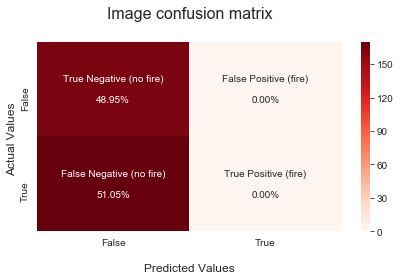

In [93]:
def plot_confusion_matrix_2(cm, normalize=True):
    
    group_names = ['True Negative (no fire)','False Positive (fire)','False Negative (no fire)','True Positive (fire)']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]

#     labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#               zip(group_names,group_counts,group_percentages)]

    if normalize:
        labels = [f"{v1}\n\n{v2}" for v1, v2 in
              zip(group_names,group_percentages)]
    else:
        labels = [f"{v1}\n\n{v2}" for v1, v2 in
              zip(group_names,group_counts)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')
    
    sns.set_style('whitegrid', {'font.family':'arial', 'font.arial':'Arial Narrow'})

    ax.set_title('Image confusion matrix\n',fontdict = { 'fontsize': 16});
    ax.set_xlabel('\nPredicted Values',fontdict = { 'fontsize': 12})
    ax.set_ylabel('Actual Values ',fontdict = { 'fontsize': 12});

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    
    ax.figure.tight_layout()

    plt.ylim(2, 0) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    
plot_confusion_matrix_2 (cm, normalize=True)

In [94]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            verticalalignment='center',
            color="black" if cm[i, j] > thresh else "black")

Confusion matrix, without normalization
[[163   0]
 [170   0]]


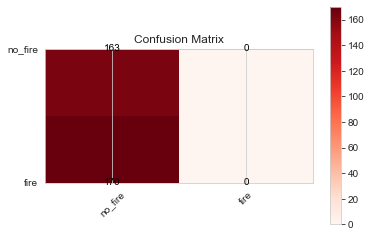

In [95]:
cm_plot_labels = ['no_fire','fire']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


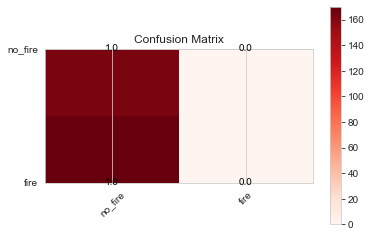

In [96]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, normalize=True, title='Confusion Matrix')

In [97]:
cmDf = pd.DataFrame(cm)
cmDf.columns = ['No fire','Fire']
cmDf.index = ['No fire','Fire']
cmDf.reset_index(inplace=True)
cmDf = cmDf.rename(columns={'index':'Labels'})
cmDf = pd.melt(cmDf, id_vars=['Labels'], value_vars=['No fire','Fire'])
cmDf

,Labels,variable,value
0,No fire,No fire,163
1,Fire,No fire,170
2,No fire,Fire,0
3,Fire,Fire,0


In [98]:
alt.Chart(cmDf).mark_rect().encode(
    x='Labels',
    y='variable',
    color='value'
)

alt.Chart(...)

## Hyperparameter tuning 

### Option 1

In [99]:
METRIC_ACCURACY = 'accuracy'

METRICS = [
    hp.Metric(
        "epoch_accuracy",
        group="validation",
        display_name="accuracy (val.)",
    ),
    hp.Metric(
        "epoch_loss",
        group="validation",
        display_name="loss (val.)",
    ),
    hp.Metric(
        "batch_accuracy",
        group="train",
        display_name="accuracy (train)",
    ),
    hp.Metric(
        "batch_loss",
        group="train",
        display_name="loss (train)",
    ),
]

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
#     metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    metrics=METRICS
    )

In [100]:
#comment / uncomment layers orrrr iterate through all combinations?
augment_layers =[
        layers.RandomFlip("vertical",input_shape=input_shape),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        #other options we can run with.. black and white, saturation, brightness, etc...
#         layers.RandomContrast(1.0, seed=100),
        ]

# tf.keras.layers.Resizing, tf.keras.layers.Rescaling, tf.keras.layers.RandomFlip, and tf.keras.layers.RandomRotation,

def augment (augment_layers):
    return keras.Sequential(augment_layers)

data_augmentation = augment(augment_layers) 

In [101]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [163]:
#https://github.com/tensorflow/tensorboard/blob/master/tensorboard/plugins/hparams/hparams_demo.py#L88

def train_test_model(hparams,epochs,augmentModel=False):
    
    if augmentModel:
        data_augmentation = augment(augment_layers)
    else:
        data_augmentation = ''
    
    
    model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax),
    ])

    model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='sparse_categorical_crossentropy',
#       metrics=['accuracy'],
      metrics=['accuracy',f1_m,precision_m, recall_m]
    )
    
    model.fit(train_images, train_labels, epochs=epochs)
    history = model.fit(train_images, train_labels, epochs=epochs) # Run with 1 epoch to speed things up for demo purposes
    histories.append(model.history)
    loss, accuracy, f1_score, precision, recall = model.evaluate(test_images, test_labels)
    losses.append(loss)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)
    precisions.append(precision)
    recalls.append(recall)
    
    predictions = model.predict(x=test_images, steps=len(test_images), verbose=0)
    cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(predictions, axis=-1))
    cms.append(cm)

    return loss, accuracy, f1_score, precision, recall

def run(run_dir, hparams, epochs, augmentModel=False):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial

        model = train_test_model(hparams,epochs,augmentModel=True)

In [164]:
session_num = 0
epochs = 50
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64]))#, 64])) #8, 16
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['RMSprop']))#,'adam', 'Nadam'])) #'sgd','Adagrad'

# epochs = 50
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'adam'} 88/91
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'RMSprop'} 88/93
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'Nadam'} 89/92
#{'num_units': 32, 'dropout': 0.1, 'optimizer': 'Nadam'} 89/92
#{'num_units': 16, 'dropout': 0.2, 'optimizer': 'RMSprop'} 84/91

# epochs = 30
#{'num_units': 64, 'dropout': 0.2, 'optimizer': 'RMSprop'} 84/89
#{'num_units': 64, 'dropout': 0.2, 'optimizer': 'Nadam'} 84/84
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'RMSprop'} 84/90
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'adam'} 80/86
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'Nadam'} 86/88
#{'num_units': 32, 'dropout': 0.2, 'optimizer': 'RMSprop'} 81/86
#{'num_units': 32, 'dropout': 0.1, 'optimizer': 'RMSprop'} 85/88
#{'num_units': 32, 'dropout': 0.1, 'optimizer': 'Nadam'} 86/88
#{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam'} 80/88
#{'num_units': 16, 'dropout': 0.1, 'optimizer': 'Nadam'} 83/87

params = []
losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []
cms = []
units = []
dropouts = []
optimizers = []
histories = []

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
#             for metrics in METRICS:
            hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            units.append(num_units)
            dropouts.append(dropout_rate)
            optimizers.append(optimizer)
            run('logs/hparam_tuning/' + run_name, hparams, epochs, augmentModel=True)
            session_num += 1

--- Starting trial: run-0
{'num_units': 64, 'dropout': 0.1, 'optimizer': 'RMSprop'}
Epoch 1/50
84/84 [==============================] - 22s 244ms/step - loss: 0.7817 - accuracy: 0.4953 - f1_m: 0.6294 - precision_m: 0.4872 - recall_m: 0.9139
Epoch 2/50
84/84 [==============================] - 20s 244ms/step - loss: 0.7110 - accuracy: 0.4945 - f1_m: 0.6577 - precision_m: 0.5025 - recall_m: 0.9693
Epoch 3/50
84/84 [==============================] - 21s 252ms/step - loss: 0.6949 - accuracy: 0.5340 - f1_m: 0.6685 - precision_m: 0.5084 - recall_m: 0.9929
Epoch 4/50
84/84 [==============================] - 20s 243ms/step - loss: 0.6385 - accuracy: 0.6318 - f1_m: 0.6728 - precision_m: 0.5145 - recall_m: 1.0000
Epoch 5/50
84/84 [==============================] - 21s 245ms/step - loss: 0.6037 - accuracy: 0.6664 - f1_m: 0.6682 - precision_m: 0.5073 - recall_m: 1.0000
Epoch 6/50
84/84 [==============================] - 20s 241ms/step - loss: 0.5788 - accuracy: 0.6860 - f1_m: 0.6712 - precision_m: 

84/84 [==============================] - 20s 239ms/step - loss: 0.3159 - accuracy: 0.8541 - f1_m: 0.6681 - precision_m: 0.5073 - recall_m: 1.0000
Epoch 3/50
84/84 [==============================] - 20s 240ms/step - loss: 0.2999 - accuracy: 0.8684 - f1_m: 0.6686 - precision_m: 0.5073 - recall_m: 1.0000
Epoch 4/50
84/84 [==============================] - 20s 239ms/step - loss: 0.3128 - accuracy: 0.8650 - f1_m: 0.6714 - precision_m: 0.5109 - recall_m: 1.0000
Epoch 5/50
84/84 [==============================] - 20s 240ms/step - loss: 0.3052 - accuracy: 0.8781 - f1_m: 0.6690 - precision_m: 0.5073 - recall_m: 1.0000
Epoch 6/50
84/84 [==============================] - 20s 241ms/step - loss: 0.2942 - accuracy: 0.8721 - f1_m: 0.6744 - precision_m: 0.5145 - recall_m: 1.0000
Epoch 7/50
84/84 [==============================] - 20s 239ms/step - loss: 0.2979 - accuracy: 0.8740 - f1_m: 0.6671 - precision_m: 0.5071 - recall_m: 0.9993
Epoch 8/50
84/84 [==============================] - 20s 240ms/step - 

84/84 [==============================] - 21s 250ms/step - loss: 0.7141 - accuracy: 0.4987 - f1_m: 0.6684 - precision_m: 0.5136 - recall_m: 0.9783
Epoch 3/50
84/84 [==============================] - 21s 247ms/step - loss: 0.6879 - accuracy: 0.5476 - f1_m: 0.6695 - precision_m: 0.5112 - recall_m: 0.9885
Epoch 4/50
84/84 [==============================] - 21s 246ms/step - loss: 0.6501 - accuracy: 0.6235 - f1_m: 0.6711 - precision_m: 0.5116 - recall_m: 1.0000
Epoch 5/50
84/84 [==============================] - 21s 247ms/step - loss: 0.6150 - accuracy: 0.6593 - f1_m: 0.6737 - precision_m: 0.5143 - recall_m: 0.9984
Epoch 6/50
84/84 [==============================] - 21s 245ms/step - loss: 0.5834 - accuracy: 0.6845 - f1_m: 0.6737 - precision_m: 0.5142 - recall_m: 0.9987
Epoch 7/50
84/84 [==============================] - 21s 247ms/step - loss: 0.5692 - accuracy: 0.6942 - f1_m: 0.6727 - precision_m: 0.5108 - recall_m: 0.9994
Epoch 8/50
84/84 [==============================] - 20s 242ms/step - 

Epoch 4/50
84/84 [==============================] - 21s 245ms/step - loss: 0.3284 - accuracy: 0.8593 - f1_m: 0.6687 - precision_m: 0.5073 - recall_m: 1.0000
Epoch 5/50
84/84 [==============================] - 21s 251ms/step - loss: 0.3244 - accuracy: 0.8612 - f1_m: 0.6719 - precision_m: 0.5111 - recall_m: 0.9991
Epoch 6/50
84/84 [==============================] - 20s 239ms/step - loss: 0.3206 - accuracy: 0.8695 - f1_m: 0.6715 - precision_m: 0.5109 - recall_m: 1.0000
Epoch 7/50
84/84 [==============================] - 20s 235ms/step - loss: 0.3030 - accuracy: 0.8812 - f1_m: 0.6721 - precision_m: 0.5111 - recall_m: 1.0000
Epoch 8/50
84/84 [==============================] - 20s 237ms/step - loss: 0.3198 - accuracy: 0.8642 - f1_m: 0.6719 - precision_m: 0.5145 - recall_m: 1.0000
Epoch 9/50
84/84 [==============================] - 21s 247ms/step - loss: 0.2992 - accuracy: 0.8714 - f1_m: 0.6715 - precision_m: 0.5109 - recall_m: 1.0000
Epoch 10/50
84/84 [==============================] - 20s 2

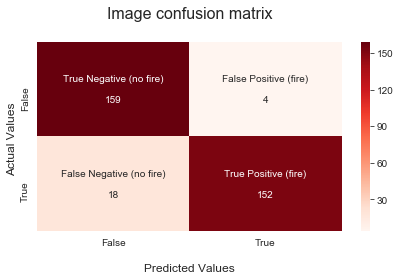

,index,loss,accuracy,f1_m,precision_m,recall_m
0,0,0.316777,0.873261,0.672786,0.514509,1.000000
1,1,0.315937,0.854080,0.668064,0.507316,1.000000
2,2,0.299868,0.868372,0.668555,0.507316,1.000000
3,3,0.312766,0.864987,0.671405,0.510913,1.000000
4,4,0.305183,0.878150,0.669006,0.507316,1.000000
5,5,0.294237,0.872132,0.674356,0.514509,1.000000
6,6,0.297885,0.874013,0.667073,0.507124,0.999256
7,7,0.303592,0.876645,0.668614,0.506956,0.998595
8,8,0.299167,0.877398,0.674840,0.514761,1.000000
9,9,0.285997,0.879654,0.668873,0.507316,1.000000


In [179]:
#dataframe assembly for model comparison
#integrate confusion matrices as well

modelDf = pd.DataFrame(list(zip(units, dropouts, optimizers, losses, accuracies, f1_scores, precisions, recalls, cms)),
               columns =['units', 'dropouts', 'optimizers', 'losses', 'accuracies', 'f1_scores', 'precisions', 'recalls', 'cms'])

modelDf['cms'].values[0]

plot_confusion_matrix_2(modelDf['cms'].values[0],normalize=False)

# line_chart(histories[0])

history_df = pd.DataFrame(histories[0].history).reset_index()
history_df

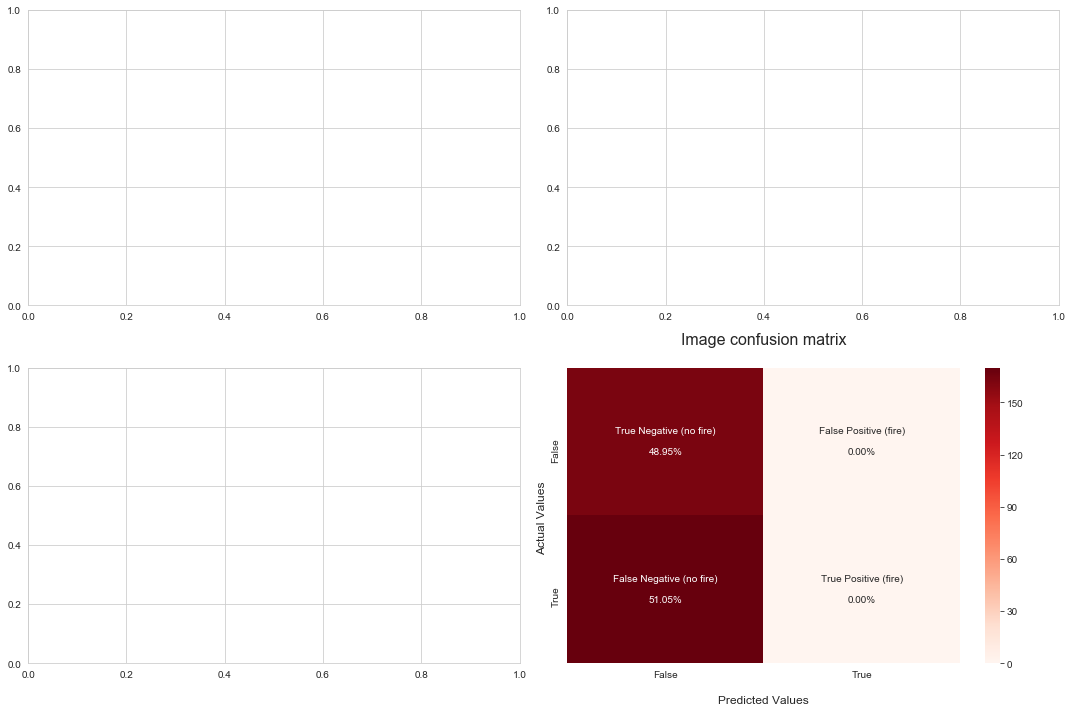

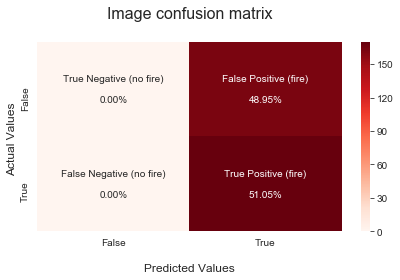

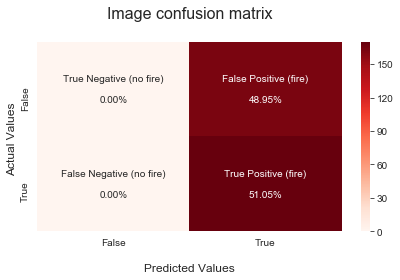

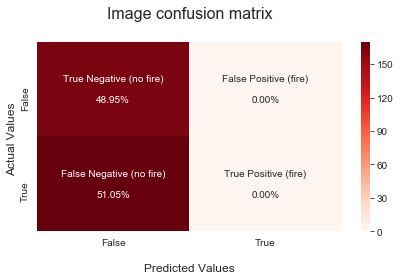

<Figure size 432x288 with 0 Axes>

In [157]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for i in range(len(list(modelDf.optimizers))):
    cls = modelDf.iloc[i,2]
    plot_confusion_matrix_2(modelDf[modelDf['optimizers']==cls]['cms'][i])
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

In [189]:
def line_chart(history):

    history_df = pd.DataFrame(history.history).reset_index()
    history_df = history_df.rename(columns={'index':'epoch'})
#     display(history_df)
    accuracy_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['accuracy', 'precision_m','recall_m'])
    loss_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['loss'])
    history_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['accuracy', 'precision_m','recall_m', 'loss'])

    performanceChart = alt.Chart(history_df,title='Model performance').mark_line(size=3).encode(
        x=alt.X('epoch',axis=alt.Axis(title='Epoch', grid=False,tickCount=10)),
        y=alt.Y('value',axis=alt.Axis(title='Accuracy/Loss',format='%')),
        color=alt.Color('variable',scale=alt.Scale(range=['#6f0000','#696969','#ff7b7b','#CC5500']),
        legend=alt.Legend(title=None,labelFont='Arial',labelColor='#696969',labelFontSize=14))
        ).properties(
        width=800,
        height=300
        ).configure_title(fontSize=30,color='#232b2b',font='Arial',anchor='start',offset=20
        ).configure_axis(labelColor='#696969',labelFont='Arial',labelFontSize=14,titleFont='Arial',titleFontSize=16,titleColor='#696969'
        )#.configure_legend(labelFontStyle='Cambria',labelFontSize=12)
    
    #save as png

    return performanceChart

line_chart(histories[0])

alt.Chart(...)

In [59]:
# %tensorboard --logdir logs/hparam_tuning
# docker run -it -p 8888:8888 -p 6006:6006 \
# tensorflow/tensorflow:nightly-py3-jupyter 

### Option 2

In [28]:
input_shape = train_images.shape[1:]
print(input_shape)

(100, 184, 3)


In [29]:
def build_model(hp):
    # create model object
    model = keras.Sequential([
    #adding first convolutional layer    
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=input_shape),
    # adding second convolutional layer 
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
    # adding flatten layer    
    keras.layers.Flatten(),
    # adding dense layer    
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    # output layer    
    keras.layers.Dense(10, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    model.summary()
    
    return model

In [30]:
#importing random search
from kerastuner import RandomSearch

#creating randomsearch object
tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 5)
# search best parameter
tuner.search(train_images,train_labels,epochs=3,validation_data=(train_images,train_labels))

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 182, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 180, 32)       9248      
_________________________________________________________________
flatten (Flatten)            (None, 552960)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                17694752  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 17,705,226
Trainable params: 17,705,226
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [31]:
model=tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 182, 48)       1344      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 178, 64)       76864     
_________________________________________________________________
flatten (Flatten)            (None, 1070848)           0         
_________________________________________________________________
dense (Dense)                (None, 32)                34267168  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 34,345,706
Trainable params: 34,345,706
Non-trainable params: 0
_________________________________________________________________


ValueError: Shapes (1070848, 32) and (1076864, 32) are incompatible

In [ ]:
model.fit(test_images,test_labels,
          epochs=10,
          validation_split=0.1,
          initial_epoch=3)
_, accuracy = model.evaluate(test_images, test_labels)
